# DEA Coastlines validation

To do:
* [X] Change output CRS to Australian Albers
* [X] Discard validation sides with multiple intersects?
* [X] Split analysis code into:
    * Aggregate multiple profiles and export into single file
    * Analyse and plot single file
* [X] Add extraction of environmental data for each profile line

## Load modules/functions


In [2]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import box
import multiprocessing as mp
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

sys.path.append('/g/data/r78/DEACoastlines/')
import deacoastlines_validation as deacl_val
import deacoastlines_statistics as deacl_stats

def to_vector(df,
              fname='test.shp',
              x='x',
              y='y',
              crs='EPSG:3577',
              output_crs='EPSG:3577'):
    
    # Convert datetimes to strings
    df = df.copy()
    is_datetime = df.dtypes == 'datetime64[ns]'
    df.loc[:, is_datetime] = df.loc[:, is_datetime].astype(str) 
    
    # Export to file
    gdf = gpd.GeoDataFrame(data=df.loc[:, df.dtypes != 'datetime64[ns]'],
                     geometry=gpd.points_from_xy(x=df[x], y=df[y]),
                     crs=crs).to_crs(output_crs).to_file(fname)
    
    return gdf


def export_eval(df, output_name, output_crs='EPSG:3577'):
    
    from shapely.geometry import box, Point, LineString

    # Extract geometries
    val_points = gpd.points_from_xy(x=df.val_x, y=df.val_y)
    deacl_points = gpd.points_from_xy(x=df.deacl_x, y=df.deacl_y)
    df_profiles = df.groupby('id').first()
    profile_lines = df_profiles.apply(
        lambda x: LineString([(x.start_x, x.start_y), (x.end_x, x.end_y)]), axis=1)

    # Export validation points
    val_gdf = gpd.GeoDataFrame(data=df,
                               geometry=val_points,
                               crs=output_crs).to_crs('EPSG:4326')
    val_gdf.to_file(f'figures/eval/{output_name}_val.geojson', 
                    driver='GeoJSON')

    # Export DEACL points
    deacl_gdf = gpd.GeoDataFrame(data=df,
                                 geometry=deacl_points,
                                 crs=output_crs).to_crs('EPSG:4326')
    deacl_gdf.to_file(f'figures/eval/{output_name}_deacl.geojson', 
                      driver='GeoJSON')

    # Export profiles
    profile_gdf = gpd.GeoDataFrame(data=df_profiles,
                                 geometry=profile_lines,
                                 crs=output_crs).to_crs('EPSG:4326')
    profile_gdf.to_file(f'figures/eval/{output_name}_profiles.geojson', 
                        driver='GeoJSON')


def deacl_val_stats(val_dist, deacl_dist, n=None, remove_bias=False):

    np.seterr(all='ignore')

    # Compute difference and bias
    diff_dist = val_dist - deacl_dist
    bias = diff_dist.mean()
    
    if remove_bias:
        deacl_dist += bias
        diff_dist = val_dist - deacl_dist

    # Compute stats
    if n is None:
        n = len(val_dist)
    else:
        n = sum(n)
        
    mae = mean_absolute_error(val_dist, deacl_dist)
    rmse = mean_squared_error(val_dist, deacl_dist)**0.5
    
    
    if n > 1:
        corr = np.corrcoef(x=val_dist, y=deacl_dist)[0][1]
        stdev = diff_dist.std()
    else:
        corr = np.nan
        stdev = np.nan

    return pd.Series({
        'n': n,
        'mae': f'{mae:.2f}',
        'rmse': f'{rmse:.2f}',
        'stdev': f'{stdev:.2f}',
        'corr': f'{corr:.3f}',
        'bias': f'{bias:.2f}',
    }).astype(float)


def rse_tableformat(not_bias_corrected, bias_corrected, groupby='source'):

    # Fix rounding and total observations
    not_bias_corrected['n'] = not_bias_corrected['n'].astype(int)
    not_bias_corrected[['bias', 'stdev', 'mae', 'rmse']] = not_bias_corrected[['bias', 'stdev', 'mae', 'rmse']].round(1)
    not_bias_corrected['n'] = not_bias_corrected.groupby(groupby)['n'].sum()
    
    # Move bias corrected values into brackets
    not_bias_corrected['MAE (m)'] = (not_bias_corrected.mae.astype('str') + ' (' + 
                                 bias_corrected.mae.round(1).astype('str') + ')')
    not_bias_corrected['RMSE (m)'] = (not_bias_corrected.rmse.astype('str') + ' (' + 
                                  bias_corrected.rmse.round(1).astype('str') + ')')
    
    # Sort by MAE, rename columns
    not_bias_corrected = (not_bias_corrected.sort_values('mae')
     .drop(['mae', 'rmse'], axis=1)
     .rename({'stdev': 'SD (m)', 'corr': 'Correlation', 'bias': 'Bias (m)'}, axis=1)
             [['n', 'Bias (m)', 'MAE (m)', 'RMSE (m)', 'SD (m)', 'Correlation']])

    return not_bias_corrected

In [ ]:
# to_vector(output_stats, fname='test6.shp', x='0_x', y='0_y', crs='EPSG:3577')

## Pre-processing


### Sunshine Coast

In [ ]:
sites = ['8.Pumicestone - Bribie', '1.Coolum-Sunshine', '5.Dicky Beach', 
        '7.Kings Beach', '3.Mooloolaba', '2.Mudjimba-Yaroomba', '6.Shelly Beach',
        '4.South Mooloolaba']

for site in sites:
    deacl_val.preprocess_sunshinecoast(site, datum=0, overwrite=True)


### Moruya

In [ ]:
deacl_val.preprocess_moruya(fname_out='output_data/moruya.csv', datum=0, overwrite=True)

### Victoria/Deakin
* [X] Renovated

In [ ]:
deacl_val.preprocess_vicdeakin(fname='input_data/vicdeakin/z_data_10cm_VIC.csv',
                               datum=0)

### WRL Narrabeen 
* [X] Renovated

In [ ]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2019.csv',
                               datum=0,
                               overwrite=True)


### NSW Beach Profile Database
* [X] Renovated

In [ ]:
with mp.Pool(mp.cpu_count()) as pool:
    for fname in glob.glob('input_data/nswbpd/*.csv'):
        pool.apply_async(deacl_val.preprocess_nswbpd, 
                         [fname, 0, False])

    pool.close()
    pool.join()
    
# fname = '/g/data/r78/DEACoastlines/validation/input_data/nswbpd/photogrammetry_Xsections_Lennox Head.csv'
# profiles_df, intercept_df = deacl_val.preprocess_nswbpd(fname, 0, True)


### City of Gold Coast
* [X] Renovated
* [ ] Fix North Kirra name

In [ ]:
sites = ['BILINGA', 'BROADBEACH', 'BURLEIGH HEADS', 'COOLANGATTA', 'CURRUMBIN',
         'DURANABH', 'FINGAL', 'GREENMOUNT HILL', 'KINGSCLIFF', 'KIRRA',
         'MAIN BEACH', 'MERMAID BEACH', 'MIAMI', 'Main Beach Cross Sections',
         'NARROWNECK', 'NO*TlH KIRRA', 'PALM BEACH', 'POINT DANGER', 
         'RAINBOW BAY', 'SEAWAY CENTRE LINE', 'SNAPPER ROCKS', 
         'SOUTH STRADBROKE', 'SURFERS PARADISE', 'THE SPIT', 'TUGUN', 
         'TWEED RIVER ENTRANCE']
# sites=['MAIN BEACH']

with mp.Pool(mp.cpu_count()) as pool:
    for site in sites:
        pool.apply_async(deacl_val.preprocess_cgc, 
                         [site, 0, False])

    pool.close()
    pool.join()


### TASMARC
* [X] Renovated

In [ ]:
# List of sites to iterate over
sites = [i.split('/')[2] for i in glob.glob('input_data/tasmarc/*/')]
# sites = sites[2:]

with mp.Pool(mp.cpu_count()) as pool:
    for site in sites:
        pool.apply_async(deacl_val.preprocess_tasmarc, 
                         [site, 0, False])

    pool.close()
    pool.join()


### WA DoT
* [X] Renovated

In [ ]:
regions_gdf = gpd.read_file('input_data/WA_tertiaryCC.shp').to_crs('EPSG:3577').iloc[::-1]
regions_gdf.index = (regions_gdf.LABEL
                     .str.replace(' - ', '_')
                     .str.replace('-', '')
                     .str.replace(' ', '')
                     .str.replace('/', '')
                     .str.replace(',', '')
                     .str.replace('_', '-')
                     .str.lower())
regions_gdf.head(1)


In [ ]:
deacl_val.coastal_transects_parallel(
    regions_gdf,
    interval=200,
    transect_length=500,
    simplify_length=200,
    transect_buffer=50,
    overwrite=False,
    output_path='input_data/coastal_transects_wadot.geojson')

In [ ]:
with mp.Pool(mp.cpu_count()-1) as pool:
    for i, _ in regions_gdf.iterrows():
        pool.apply_async(deacl_val.preprocess_wadot, 
                         [regions_gdf.loc[[i]], False])

    pool.close()
    pool.join()


### WA DoT - Stirling

In [ ]:
deacl_val.preprocess_stirling(fname_out='output_data/stirling_stirling.csv',
                              datum=0)

### SA Department of Environment and Water

In [443]:
sites = ['200048',
 '320010',
 '320011',
 '330005',
 '330014',
 '425001',
 '425002',
 '440004',
 '525019',
 '525022',
 '525023',
 '530009',
 '545001',
 '555007',
 '555012',
 '815013']

fname = f'input_data/sadew/{sites[15]}.CSV'
print(fname)
profile_df = deacl_val.preprocess_sadew(fname, datum=0, overwrite=True)
profile_df.head(2)

input_data/sadew/815013.CSV


,x,y,profile,z,date,beach,section,id,source,name,start_x,start_y,end_x,end_y,distance
0,438388.090045,-3.907657e+06,815013,6.05,1988-12-15,sadew,all,sadew_all_815013,hydrographic survey,sadew,438388.090045,-3.907657e+06,438099.648771,-3.907630e+06,0.00000
1,438387.591322,-3.907657e+06,815013,6.16,1988-12-15,sadew,all,sadew_all_815013,hydrographic survey,sadew,438388.090045,-3.907657e+06,438099.648771,-3.907630e+06,0.50118


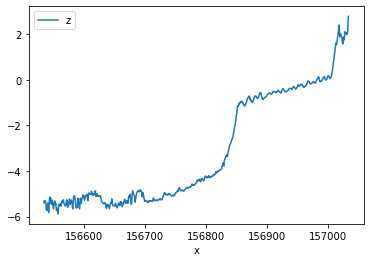

In [424]:
unique_years = profile_df.date.unique()[-5]
profile_df.loc[profile_df.date == unique_years].plot(x='x', y='z')

In [57]:
# from pathlib import Path
# for fname in fname_list:
#     preprocess_sadew(fname, datum=0, overwrite=False)

fname_list = glob.glob('input_data/sadew/*.CSV')    

with mp.Pool(mp.cpu_count()-1) as pool:
    for fname in fname_list:
        pool.apply_async(deacl_val.preprocess_sadew, 
                         [fname, 0, True])

    pool.close()
    pool.join()


In [139]:
# profile_df['date'] = profile_df['variable'].str[1:].str.strip()
# profile_df['date'] = pd.to_datetime(profile_df['date'], format='%d%m%Y')
# profile_df = profile_df.drop('variable', axis=1)

In [147]:
pd.to_datetime(profile_df['date'], errors='coerce',format='%d%m%Y')

0       1985-12-02
1       1985-12-02
2       1985-12-02
3       1985-12-02
4       1985-12-02
           ...    
70980   2019-12-03
70981   2019-12-03
70982   2019-12-03
70983   2019-12-03
70984   2019-12-03
Name: date, Length: 46616, dtype: datetime64[ns]

In [145]:
profile_df['date'].unique()

array(['02121985', '09121988', '05121991', '02121992', '30111993',
       '30111994', '30111995', '01121997', '23111998', '27112000',
       '06122001', '07122001', '30112005', '31112005', '04122007',
       '05122007', '03122008', '04122008', '03122009', '04122009',
       '09122010', '05122012', '06122012', '27042015', '28042015',
       '05122016', '06122016', '15122017', '16122017', '14112018',
       '15112018', '02122019', '03122019'], dtype=object)

In [111]:
fname_list = glob.glob('input_data/sadew/*.CSV')

In [101]:
out = []

for fname in fname_list:
    
    # Load data and set nodata values to NaN
#     print(fname)
    wide_df = pd.read_csv(fname, nrows=1, usecols=[0, 2, 3]).replace(-9999, np.nan)
    wide_df.columns = wide_df.columns.str.lower()
    wide_df = wide_df.rename({'easting': 'x', 'northing': 'y'}, axis=1)
    if (wide_df.x == 'EASTING').any():
        print(fname)
    
    out.append(wide_df)  


In [112]:
df = pd.concat(out)
gdf = gpd.GeoDataFrame(data={'profile': df.profile}, geometry=gpd.points_from_xy(x=df.x, y=df.y), crs="EPSG:28353")

In [113]:
gdf.to_file('sa_test_UTM53.shp')

## Analysis
To investigate:
* [ ] **Cluster of outliers at Evans Head and Broadwater**
* [ ] **Extreme outliers at Flynn's Beach**
* [ ] **Skewed result at Gerringong Harbour**
* [ ] Outliers in Hargrave's Beach
* [ ] Remaining outliers at Jimmy's Beach
* [ ] Outliers at Shellharbour Little Lake
* [ ] **Several remaining outliers at Swansea Belmont**
* [ ] **Major issues with Valla Beach**

In [1]:
import random 
val_paths = glob.glob('output_data/*.csv')
random.shuffle(val_paths)
# deacl_path = '/g/data/r78/DEACoastlines/DEACoastLines_coastlines_v1.0.0.shp'
deacl_path = '/g/data/r78/DEACoastlines/DEACoastlines_coastlines_v1.1.3.shp'
# deacl_path = '/g/data/r78/DEACoastlines/cloud_buffer_test_v1.1.0.shp'

prefix='v1.1.3'

with mp.Pool(6) as pool:
    for val_path in val_paths:
        
        # Run analysis and close resulting figure
        pool.apply_async(deacl_val.deacl_validation, 
                         [val_path, deacl_path, 0, prefix, False])

    pool.close()
    pool.join()

NameError: name 'glob' is not defined

In [186]:
for val_path in val_paths:
    try:
        deacl_val.deacl_validation(val_path, deacl_path, 0, prefix, False)
    except:
        pass

In [4]:
prefix = 'v1.1.3'

In [5]:
# Load all results into a single file
print('Combining data')
stats_list = glob.glob(f'{prefix}_*.csv')
stats_df = pd.concat([pd.read_csv(csv) for csv in stats_list])
stats_df.to_csv('deacl_all_results.csv', index=False)
deacl_val_stats(stats_df.val_dist, stats_df.deacl_dist, n=stats_df.n)

Combining data


n        57662.000
mae         13.740
rmse        19.260
stdev       16.820
corr         0.991
bias         9.370
dtype: float64

In [6]:
stats_df = stats_df.loc[stats_df.name == 'sunshinecoast']

In [44]:
deacl_val_stats(stats_df.val_dist, stats_df.deacl_dist, n=stats_df.n, remove_bias=True)

n        184.00
mae        6.64
rmse      13.32
stdev     13.36
corr       1.00
bias       9.58
dtype: float64

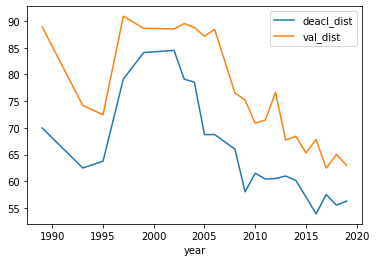

In [137]:
test = stats_df.loc[stats_df.id == 'sadew_all_200020']
test.plot(x='year', y='deacl_dist')
test.plot(x='year', y='val_dist', ax=plt.gca())

In [2]:
# Export evaluation vector
output_name = 'all_profiles'
export_eval(stats_df, output_name)

NameError: name 'stats_df' is not defined

### Plot and analyse results

In [3]:
# Read in results
stats_df = pd.read_csv('deacl_all_results.csv')
stats_df.head()

,id,year,beach,section,profile,name,source,certainty,n,lon,...,start_y,end_x,end_y,val_x,val_y,val_dist,deacl_x,deacl_y,deacl_dist,error_m
0,pointann-pointhood_all_7435,2008,pointann-pointhood,all,7435,wadot,aerial photogrammetry,good,1,119.507,...,-3.806676e+06,-1.142207e+06,-3.806464e+06,-1.142461e+06,-3.806583e+06,219.586065,-1.142461e+06,-3.806583e+06,219.736830,-0.150766
1,pointann-pointhood_all_7436,2008,pointann-pointhood,all,7436,wadot,aerial photogrammetry,good,1,119.506,...,-3.806495e+06,-1.142291e+06,-3.806283e+06,-1.142572e+06,-3.806415e+06,189.909898,-1.142579e+06,-3.806417e+06,183.155542,6.754355
2,pointann-pointhood_all_7437,2008,pointann-pointhood,all,7437,wadot,aerial photogrammetry,good,1,119.506,...,-3.806314e+06,-1.142376e+06,-3.806102e+06,-1.142679e+06,-3.806244e+06,165.554717,-1.142683e+06,-3.806246e+06,160.903462,4.651255
3,pointann-pointhood_all_7438,2008,pointann-pointhood,all,7438,wadot,aerial photogrammetry,good,1,119.505,...,-3.806133e+06,-1.142461e+06,-3.805921e+06,-1.142771e+06,-3.806066e+06,157.802766,-1.142780e+06,-3.806070e+06,148.022147,9.780619
4,pointann-pointhood_all_7439,2008,pointann-pointhood,all,7439,wadot,aerial photogrammetry,good,1,119.504,...,-3.805951e+06,-1.142545e+06,-3.805740e+06,-1.142845e+06,-3.805880e+06,169.048967,-1.142859e+06,-3.805886e+06,154.159998,14.888968


In [9]:
len(stats_df.smartline.unique())

39

#### Validation dataset stats

Plot of validation sites:

In [4]:
by_source = stats_df.groupby('name').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_source_nobias = stats_df.groupby('name').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

rse_tableformat(by_source, by_source_nobias, 'name')


,n,Bias (m),MAE (m),RMSE (m),SD (m),Correlation
name,,,,,,
wrl,2446,4.2,5.7 (4.5),7.3 (5.9),6.0,0.971
sadew,3908,2.7,9.0 (8.8),12.1 (11.8),11.8,0.996
sunshinecoast,184,9.6,10.4 (6.6),16.4 (13.3),13.4,1.000
vicdeakin,1573,10.1,11.0 (7.0),13.4 (8.8),8.8,0.853
tasmarc,478,8.6,11.8 (9.8),15.3 (12.7),12.7,0.868
wadot,18945,5.4,11.9 (11.1),18.7 (17.9),17.9,0.954
nswbpd,20596,11.1,14.3 (11.3),19.0 (15.4),15.4,0.990
cgc,8895,22.6,23.2 (10.2),26.7 (14.2),14.2,0.942
moruya,637,31.7,32.4 (13.5),36.3 (17.6),17.8,0.750


In [77]:
stats_gdf = gpd.GeoDataFrame(data=stats_df,
                             geometry=gpd.points_from_xy(
                                 x=stats_df.lon,
                                 y=stats_df.lat,
                                 crs='EPSG:4326')).to_crs('EPSG:3577')

stats_gdf.to_file('../bishoptaylor_2020/Validation_extent/validation_points.shp')

# Load and reverse buffer Australian boundary
aus_inside = (gpd.read_file('/g/data/r78/rt1527/shapefiles/australia/australia/cstauscd_r.shp')
 .query("FEAT_CODE=='mainland'")
 .to_crs('EPSG:3577')
 .assign(dissolve=1)
 .dissolve('dissolve')
 .simplify(10000)
 .buffer(-100000)
 .buffer(50000))

# Compute convex hulls for each validation dataset
convex_hulls = stats_gdf.dissolve('name').convex_hull.buffer(50000)

# Clip convex hulls by Australia coastline
gpd.overlay(gpd.GeoDataFrame(geometry=convex_hulls), 
            gpd.GeoDataFrame(geometry=aus_inside), 
            how='difference').buffer(100000).to_file('../bishoptaylor_2020/Validation_extent/validation_extent.shp')

Number of validation sites by source:

In [27]:
stats_df['n'].sum()

57662

In [26]:
stats_df.groupby("name")['n'].sum()

name
cgc               8895
moruya             637
nswbpd           20596
sadew             3908
sunshinecoast      184
tasmarc            478
vicdeakin         1573
wadot            18945
wrl               2446
Name: n, dtype: int64

In [36]:
stats_df.groupby("name")['year'].agg([np.min,np.max])

,amin,amax
name,,
cgc,1988,2018
moruya,2007,2018
nswbpd,1988,2019
sunshinecoast,1988,1993
tasmarc,2005,2019
vicdeakin,2018,2019
wadot,1988,2016
wrl,1988,2019


In [5]:
rename_dict = dict(zip(stats_df.groupby(["source"])['year'].count().sort_values().index[0:4], ['Other']*4))
rename_dict = {**rename_dict, **{'aerial photogrammetry': 'Aerial photogrammetry',
                                 'drone photogrammetry': 'Drone photogrammetry',
                                 'hydrographic survey': 'Hydrographic survey',
                                 'lidar': 'LiDAR'}}

counts_per_year = (stats_df
                   .pipe(lambda x: x.assign(source_updated = x.source.replace(rename_dict)))
                   .groupby(["year", "source_updated"])['n']
                   .sum()
                   .unstack()) 
counts_per_year = counts_per_year / counts_per_year.sum().sum()
counts_per_year

source_updated,Aerial photogrammetry,Drone photogrammetry,Hydrographic survey,LiDAR,Other
year,,,,,
1988,0.012407,NaN,0.002898,NaN,0.000937
1989,0.002742,NaN,0.003731,NaN,0.000868
1990,0.023443,NaN,0.006490,NaN,0.000521
1991,0.012112,NaN,0.003453,NaN,0.000607
1992,0.001301,NaN,0.003661,NaN,0.000694
1993,0.047216,NaN,0.003922,0.002221,0.001024
1994,0.012095,NaN,0.003592,NaN,0.000521
1995,0.009526,NaN,0.005778,NaN,0.000954
1996,0.037412,NaN,0.004893,NaN,0.000781


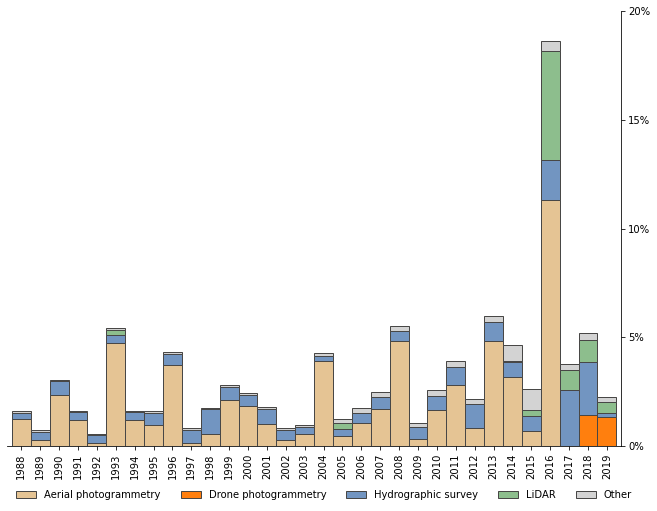

In [7]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1,1, figsize=(11, 8))
counts_per_year.plot(ax=ax, 
                     kind='bar', 
                     stacked=True, 
                     width=1.0, 
                     edgecolor='#484746', 
                     linewidth=1.0, 
                     color=['#e5c494', '#ff7f0e', '#7295c1', '#8dbe8d', 'lightgrey']
                    ) 
ax.yaxis.set_ticks_position('right')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.label.set_visible(False)
plt.yticks([0, 0.05, 0.10, 0.15, 0.20], ['0%', '5%', '10%', '15%', '20%']);
plt.legend(loc="upper left", ncol=5, bbox_to_anchor=(0, -0.08), fancybox=False, shadow=False, frameon=False)

# Export to file
fig.savefig(fname='../bishoptaylor_2020/Validation_extent/validation_temporal2.png', 
            dpi=300, pad_inches=0, bbox_inches="tight")

In [6]:
stats_df.groupby("name")["source"].unique()

name
cgc                                          [hydrographic survey]
moruya                                           [emery/levelling]
nswbpd           [lidar, aerial photogrammetry, terrestrial las...
sadew                                        [hydrographic survey]
sunshinecoast                                [hydrographic survey]
tasmarc               [gps, total station, emery/levelling, lidar]
vicdeakin                                   [drone photogrammetry]
wadot                                      [aerial photogrammetry]
wrl                                    [emery/levelling, gps, nan]
Name: source, dtype: object

#### Results by substrate

In [19]:
rename_dict = {
    'Beachrock undiff': 'rocky',
    'Beachrock undiff dominant': 'rocky',
    'Boulder or shingle-grade beach undiff': 'rocky',
    'Boulder groyne or breakwater undiff': 'rocky',
    'Flat boulder deposit (rock) undiff': 'rocky',
    'Hard bedrock shore': 'rocky',
    'Hard bedrock shore inferred': 'rocky',
    'Hard rock cliff (>5m)': 'rocky',
    'Hard rocky shore platform': 'rocky',
    'Rocky shore platform (undiff)': 'rocky',
    'Sloping boulder deposit (rock) undiff': 'rocky',
    'Sloping hard rock shore': 'rocky',
    'Sloping soft `bedrock¿ shore': 'rocky',
    'Sloping soft ‘bedrock’ shore': 'rocky',
    'Soft `bedrock¿ shore inferred': 'rocky',
    'Soft `bedrock¿ shore platform': 'rocky',
    'Beach (sediment type undiff)': 'sandy',
    'Fine-medium sand beach': 'sandy',
    'Fine-medium sandy tidal flats': 'sandy',
    'Mixed sand and shell beach': 'sandy',
    'Mixed sandy shore undiff': 'sandy',
    'Perched sandy beach (undiff)': 'sandy',
    'Sandy beach undiff': 'sandy',
    'Sandy beach with cobbles/pebbles (rock)': 'sandy',
    'Sandy shore undiff': 'sandy',
    'Sandy tidal flats': 'sandy',
    'Sandy tidal flats with coarse stony debris': 'sandy',
    'Sandy tidal flats, no bedrock protruding': 'sandy',
    'Sloping coffee rock deposit': 'rocky',
    'Muddy tidal flats': 'muddy',
    'Tidal flats (sediment undiff)': 'muddy',
    'Artificial shoreline undiff': 'rocky',
    'Artificial boulder structures undiff': 'rocky',
    'Boulder revetment': 'rocky',
    'Boulder seawall': 'rocky',
    'Concrete sea wall': 'rocky',
    'Piles (Jetty)': 'rocky',
    'Coarse sand beach': 'sandy'
}

# Rename smartline categories to smaller subset
stats_df['smartline'] = stats_df.smartline.replace(rename_dict)

# Stats by substrate, no bias correction
by_smartline = stats_df.groupby('smartline').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_smartline_nobias = stats_df.groupby('smartline').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

out = rse_tableformat(by_smartline, by_smartline_nobias, 'smartline')
out


,n,Bias (m),MAE (m),RMSE (m),SD (m),Correlation
smartline,,,,,,
rocky,2638,-0.2,10.7 (10.7),16.6 (16.6),16.6,0.996
sandy,53330,10.3,13.8 (11.4),19.2 (16.2),16.2,0.991
muddy,1248,-0.6,16.6 (16.7),24.6 (24.6),24.6,0.961


In [28]:
out['n'] / out['n'].sum()

smartline
rocky    0.046106
sandy    0.932082
muddy    0.021812
Name: n, dtype: float64

In [21]:
stats_df.groupby('name')['smartline'].unique()

name
cgc                     [sandy, rocky, nan]
moruya                              [sandy]
nswbpd                  [sandy, rocky, nan]
sadew                        [sandy, rocky]
sunshinecoast                [rocky, sandy]
tasmarc                             [sandy]
vicdeakin                    [sandy, rocky]
wadot            [sandy, rocky, muddy, nan]
wrl                                 [sandy]
Name: smartline, dtype: object

#### Results by slope

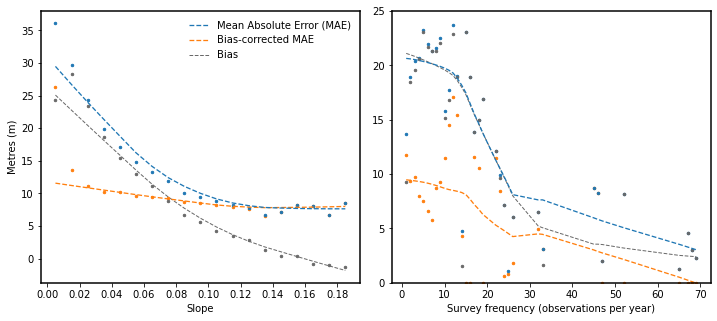

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

by_slope_nobias.plot.scatter(x='slope', y='mae', c='C1', ax=ax1, s=6)
by_slope.plot.scatter(x='slope', y='mae', c='C0', ax=ax1, s=6)
by_yearly_obs_nobias.plot.scatter(x='n', y='mae', c='C1', ax=ax2, s=6)
by_yearly_obs.plot.scatter(x='n', y='mae', c='C0', ax=ax2, s=6)
by_slope.plot.scatter(x='slope', y='bias', c='dimgrey', ax=ax1, s=6)
by_yearly_obs.plot.scatter(x='n', y='bias', c='dimgrey', ax=ax2, s=6)

# Add trendline and restrict extent
z = lowess(by_slope['mae'], by_slope['slope'])
ax1.plot(z[:, 0], z[:, 1], '--', color = 'C0', linewidth = 1.3, zorder=3);
z = lowess(by_slope_nobias['mae'], by_slope_nobias['slope'])
ax1.plot(z[:, 0], z[:, 1], '--', color = 'C1', linewidth = 1.3);
z = lowess(by_yearly_obs['mae'], by_yearly_obs['n'])
ax2.plot(z[:, 0], z[:, 1], '--', color = 'C0', linewidth = 1.3, zorder=3);
z = lowess(by_yearly_obs_nobias['mae'], by_yearly_obs_nobias['n'])
ax2.plot(z[:, 0], z[:, 1], '--', color = 'C1', linewidth = 1.3);
z = lowess(by_slope['bias'], by_slope['slope'])
ax1.plot(z[:, 0], z[:, 1], '--', color = 'dimgrey', linewidth = 1.0, zorder=0);
z = lowess(by_yearly_obs['bias'], by_yearly_obs['n'])
ax2.plot(z[:, 0], z[:, 1], '--', color = 'dimgrey', linewidth = 1.0, zorder=0);

# Set axis limita
ax1.set_xticks(np.arange(0, 0.2, 0.02))
ax1.set_ylabel('Metres (m)')
ax1.set_xlabel('Slope')
ax2.set_xlabel('Survey frequency (observations per year)')
ax2.set_ylim(0, 25)
ax2.yaxis.label.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0)
ax1.legend(['Mean Absolute Error (MAE)', 'Bias-corrected MAE', 'Bias'], frameon=False)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(1.5)
    ax2.spines[axis].set_linewidth(1.5)

plt.savefig(fname=f'../bishoptaylor_2020/SlopeObs/FigureX_Effectofslopeandobs.png', 
            bbox_inches='tight',
            transparent=True,
            pad_inches=0.05, dpi=300)

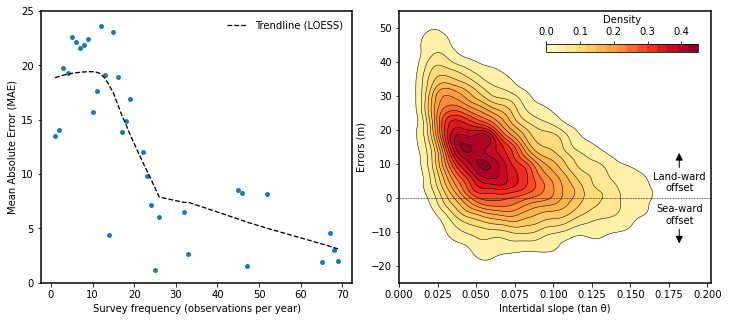

In [140]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# by_yearly_obs = stats_df.groupby('n').apply(
#     lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n, False)).drop('n', axis=1).reset_index()
by_yearly_obs.plot.scatter(x='n', y='mae', ax=ax2, s=15)


for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(1.5)
    ax2.spines[axis].set_linewidth(1.5)

by_slope = stats_df[['slope', 'error_m']].dropna(axis=0) 
by_slope['slope'] = by_slope.slope.abs()

sns.kdeplot(ax=ax1,
            data=by_slope['slope'],
            data2=by_slope['error_m'],
            cmap='YlOrRd',
            legend=True, 
            cbar=True,
            shade=True,
            shade_lowest=False,
            levels=16,
            clip=([0, 0.202], [-20, 55]),
            cbar_kws={"use_gridspec":False, 
                      "location":"top",
                      "shrink":0.5, 
                      "anchor":(0.92, 0.0),
                      'label': 'Density',
                      'ticklocation':"left",
                      "ticks": [0, 0.1, 0.2, 0.3, 0.4, 0.5]}
           )

sns.kdeplot(ax=ax1,
            data=by_slope['slope'],
            data2=by_slope['error_m'],
            colors="black",
            shade=False,
            shade_lowest=False,
            levels=16,
            clip=([0, 0.202], [-20, 55]),
            linewidths=0.5
#             linestyles=":"
           )

# Add trendline and restrict extent
z = lowess(by_yearly_obs['mae'], by_yearly_obs['n'])
ax2.plot(z[:, 0], z[:, 1], '--', color = 'black', linewidth = 1.3, zorder=3);

ax1.set(ylim=(-25, 55))
# # Set axis limita
# ax1.set_xticks(np.arange(0, 0.2, 0.02))
ax1.set_ylabel('Errors (m)')
ax2.set_ylabel('Mean Absolute Error (MAE)')
ax1.set_xlabel('Intertidal slope (tan θ)')
ax2.set_xlabel('Survey frequency (observations per year)')
ax2.set_ylim(0, 25)
plt.subplots_adjust(wspace=0.15, hspace=0)
ax2.legend(['Trendline (LOESS)'], frameon=False)
ax1.axhline(y=0, linestyle='--', color='black', linewidth = 0.5)


ax1.annotate('Landward\nbias', 
             xytext=(0.1817, 2), 
             xy=(0.1817, 13.8), 
             arrowprops={'arrowstyle': '-|>', 
                         'facecolor': 'black', 
                         'mutation_scale': 15}, 
             ha='center')
ax1.annotate('Seaward\nbias', 
             xytext=(0.1817, -7.5), 
             xy=(0.1817, -14), 
             arrowprops={'arrowstyle': '-|>', 
                         'facecolor': 'black', 
                         'mutation_scale': 15}, 
             ha='center')

plt.savefig(fname=f'../bishoptaylor_2020/SlopeObs/FigureX_Effectofslopeandobs.png', 
            bbox_inches='tight',
            transparent=True,
            pad_inches=0.05, dpi=300)



#### Temporal plots

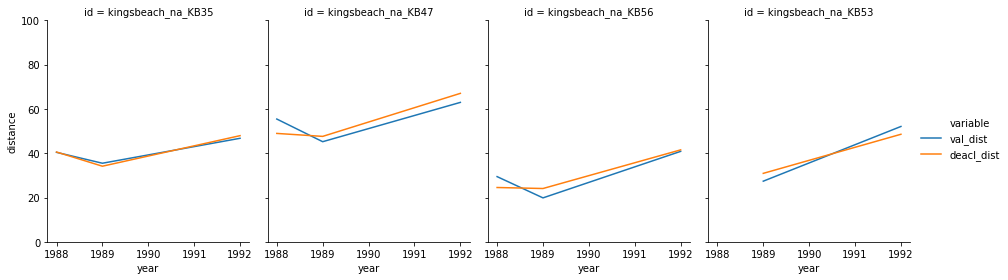

In [37]:
subpixel_subset = ['currumbin_eta_27', 'tugun_eta_25', 'narrabeen_all_pf8']
subpixel_subset = ['kingsbeach_na_KB35', 'kingsbeach_na_KB47', 'kingsbeach_na_KB56', 'kingsbeach_na_KB53']
is_subpixel = stats_df[stats_df.id.isin(subpixel_subset)]

is_subpixel_stats = is_subpixel.groupby('id').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))

is_subpixel_merged = pd.merge(
    left=is_subpixel,
    right=is_subpixel_stats,
    how="inner",
    on='id')

is_subpixel_merged['deacl_dist'] += is_subpixel_merged['bias']

is_subpixel_melted = pd.melt(is_subpixel_merged, 
                    id_vars=['id', 'year'], 
                    value_vars=['val_dist', 'deacl_dist'], 
                    value_name='distance')


# Plot in facets
out = sns.relplot(
    data=is_subpixel_melted,
    x="year", y="distance", hue='variable', kind="line",
    col="id",
#     facet_kws={'sharey': False, 'sharex': False}
#     facet_kws={'ymin': 0},
    aspect=0.8, height=4
    
)
out.set(ylim=(0, 100))

In [22]:
stats_df.beach.unique()

array(['mooloolaba', 'southmooloolaba', 'kingsbeach', 'mudjimba-yaroomba',
       'dickybeach', 'coolum-sunshine'], dtype=object)

In [15]:
id_var = 'id'
high_freq = stats_df.groupby(id_var).filter(lambda x: len(x) >= 1)
high_freq_stats = high_freq.groupby(id_var).apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))

In [16]:
high_freq_merged = pd.merge(
    left=high_freq,
    right=high_freq_stats,
    how="inner",
    on=id_var)

In [17]:
high_freq_merged['deacl_dist'] += high_freq_merged['bias']

In [18]:
high_freq_melted = pd.melt(high_freq_merged, #.query('corr > 0.8'), 
                    id_vars=[id_var, 'year'], 
                    value_vars=['val_dist', 'deacl_dist'], 
                    value_name='distance')
high_freq_melted.head()

,id,year,variable,distance
0,mooloolaba_na_522,1993,val_dist,1020.995529
1,mooloolaba_na_523,1993,val_dist,975.308240
2,mooloolaba_na_527,1993,val_dist,850.088450
3,mooloolaba_na_530,1993,val_dist,2906.751169
4,mooloolaba_na_532,1993,val_dist,2669.300318


In [28]:
high_freq_melted.id.unique()

array(['mooloolaba_na_522', 'mooloolaba_na_523', 'mooloolaba_na_527',
       'mooloolaba_na_530', 'mooloolaba_na_532', 'southmooloolaba_na_494',
       'southmooloolaba_na_496', 'southmooloolaba_na_500',
       'southmooloolaba_na_502', 'southmooloolaba_na_504',
       'southmooloolaba_na_506', 'southmooloolaba_na_510',
       'southmooloolaba_na_512', 'southmooloolaba_na_514',
       'kingsbeach_na_KB1', 'kingsbeach_na_KB2', 'kingsbeach_na_KB21',
       'kingsbeach_na_KB22', 'kingsbeach_na_KB23', 'kingsbeach_na_KB24',
       'kingsbeach_na_KB25', 'kingsbeach_na_KB25.5', 'kingsbeach_na_KB26',
       'kingsbeach_na_KB27', 'kingsbeach_na_KB28', 'kingsbeach_na_KB29',
       'kingsbeach_na_KB30', 'kingsbeach_na_KB31', 'kingsbeach_na_KB32',
       'kingsbeach_na_KB34', 'kingsbeach_na_KB35', 'kingsbeach_na_KB37',
       'kingsbeach_na_KB38', 'kingsbeach_na_KB39', 'kingsbeach_na_KB40',
       'kingsbeach_na_KB41', 'kingsbeach_na_KB42', 'kingsbeach_na_KB43',
       'kingsbeach_na_KB44', 'kings

In [19]:
high_freq_melted['distance'] = high_freq_melted.distance - high_freq_melted.groupby(id_var).distance.transform('min')

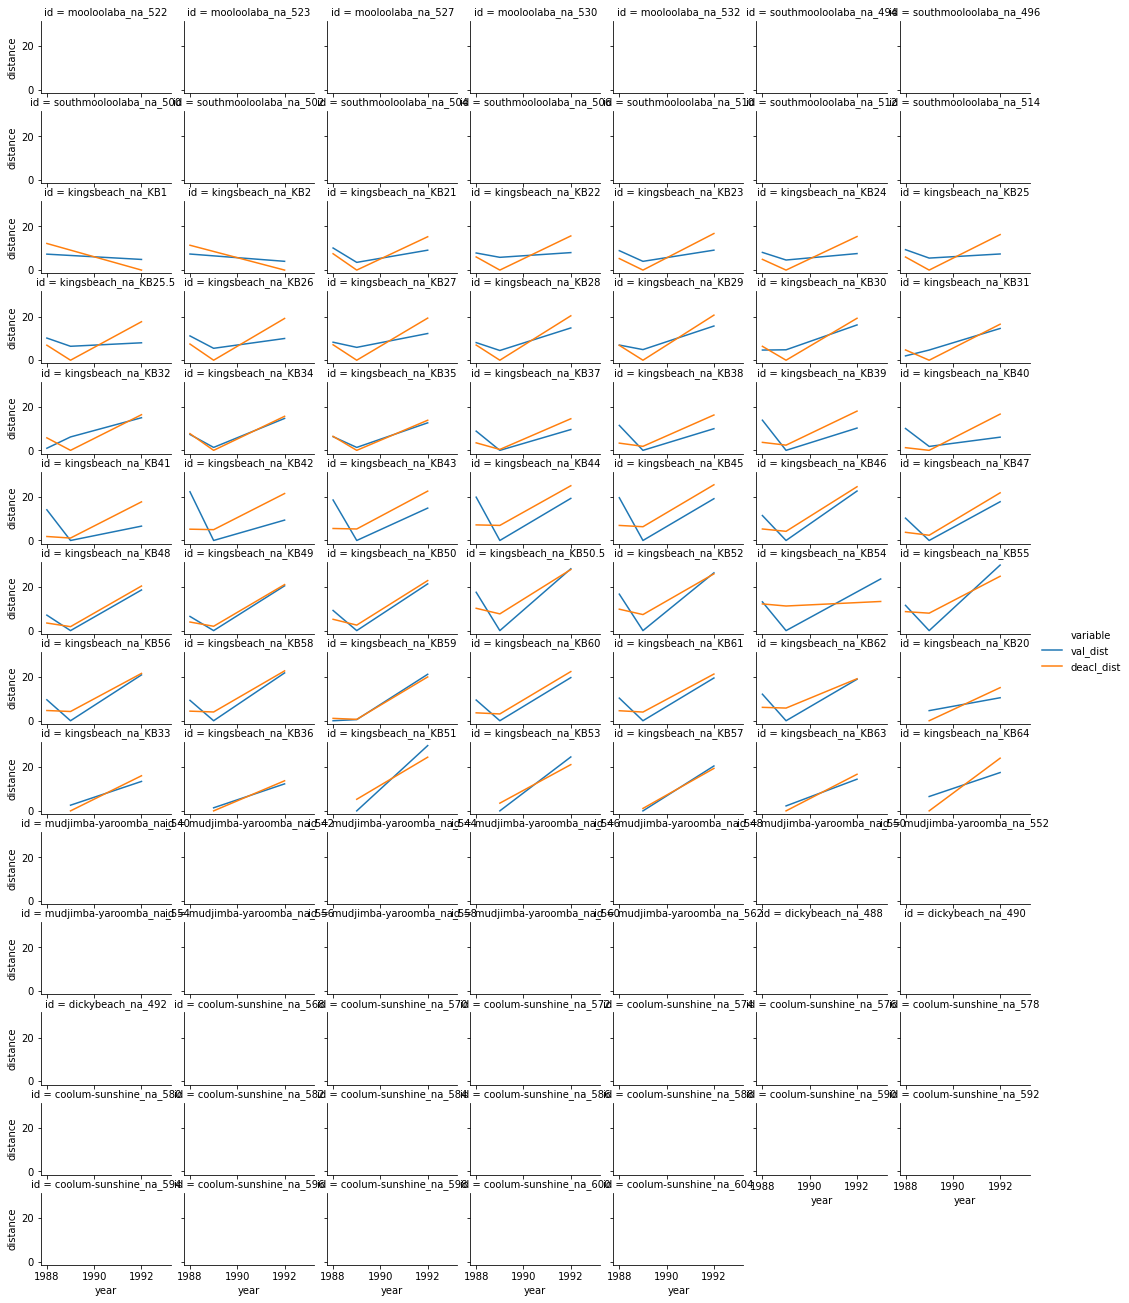

In [20]:
# Plot the lines on two facets
g = sns.relplot(
    data=high_freq_melted,
    x="year", y="distance", hue='variable', kind="line",
    col=id_var, col_wrap=7,
#     facet_kws={'sharey': False, 'sharex': True},
    aspect=1.6, height=1.3
    
)

plt.subplots_adjust(hspace=0.25, wspace=0.10)


In [136]:
g.fig.savefig(f"sa_dew_prelim2.png", dpi=100)

Text(0.5, 1.0, 'Profile 200020')

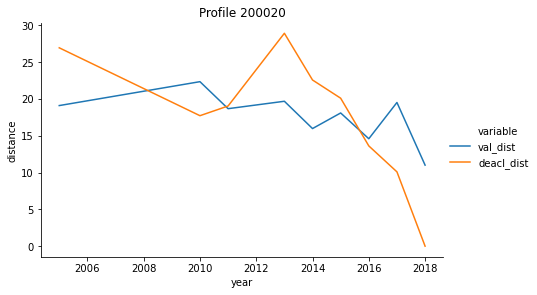

In [358]:
test = high_freq_melted.loc[high_freq_melted.profile == 715009]

# Plot the lines on two facets
g = sns.relplot(
    data=test,
    x="year", y="distance", hue='variable', kind="line",
    aspect=1.6, height=4,  
)

# plt.gca().set(ylim=(40, 110))
# plt.gca().axhspan(62, 92, alpha=0.16, color='grey')
plt.gca().set_title('Profile 200020')

#### Results by profile
ID filtered to multi-year observations

In [ ]:
by_id = stats_df.groupby('id').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist))

In [ ]:
by_id.query("n > 5").astype('float').boxplot(column='mae')

In [ ]:
by_id.query("n > 5")['mae'].astype('float').plot.hist(bins=30)

#### Effect of validation source

In [25]:
by_source = stats_df.groupby('source').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_source_nobias = stats_df.groupby('source').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

rse_tableformat(by_source, by_source_nobias)


,n,Bias (m),MAE (m),RMSE (m),SD (m),Correlation
source,,,,,,
gps,1665,6.6,8.1 (6.7),11.8 (9.8),9.8,0.930
total station,63,5.8,10.0 (9.0),13.5 (12.2),12.3,0.875
drone photogrammetry,1573,10.1,11.0 (7.0),13.4 (8.8),8.8,0.853
aerial photogrammetry,34559,7.6,12.6 (11.2),18.5 (16.9),16.9,0.981
emery/levelling,1798,12.2,14.6 (12.2),20.0 (15.9),15.9,0.841
terrestrial laser scanning,228,16.8,16.8 (1.3),16.9 (1.6),1.6,0.998
lidar,4756,14.0,17.3 (11.9),21.4 (16.2),16.2,0.992
hydrographic survey,12987,14.8,17.5 (12.6),22.1 (16.4),16.4,0.997


#### Effect of yearly validation observations

In [29]:
stats_df.n.sum()

57662

In [30]:
stats_df[stats_df.n > 1].n.sum()

13352

In [31]:
1 - (stats_df[stats_df.n == 1].n.sum() / stats_df.n.sum())

0.23155631091533424

In [32]:
stats_df[stats_df.n >= 12].n.sum()

2292

In [33]:
stats_df[stats_df.n >= 12].n.sum()  / stats_df.n.sum()

0.03974888141236863

In [ ]:
stats_df[stats_df.n >= 12].beach.unique()

In [ ]:
by_yearly_obs = stats_df.groupby('n').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, False)).drop('n', axis=1).reset_index()

In [ ]:

by_yearly_obs = stats_df.groupby('n').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, False)).drop('n', axis=1).reset_index()
by_yearly_obs.plot.scatter(x='n', y='mae')

# Add trendline and restrict extent
z = lowess(by_yearly_obs['mae'], by_yearly_obs['n'])
plt.gca().plot(z[:, 0], z[:, 1], '--', color = 'black', linewidth = 1, );


In [ ]:
by_slope = stats_df[['n', 'error_m']].dropna(axis=0) 
by_slope['error_m'] = by_slope.error_m.abs()

plt.figure(figsize=(8, 8))
a = sns.kdeplot(ax=plt.gca(),
            data=by_slope['n'],
            data2=by_slope['error_m'],
            cmap='YlOrRd',
            shade=True,
            shade_lowest=False,
#             levels=15,
#             clip=([0, 0.18], [-20, 55]),
           )

# # Add trendline and restrict extent
# z = lowess(by_slope['error_m'], by_slope['slope'])
# plt.gca().plot(z[:, 0], z[:, 1], '--', color = 'black', linewidth = 1, )
# a.set(xlim=(0, 0.18))
# a.set(ylim=(-20, 55))

In [ ]:
by_slope.plot.scatter(x='n', y='error_m')

### Plots

In [ ]:
# # Export evaluation vector
output_name = 'vicdeakin'
export_eval(stats_df, output_name)

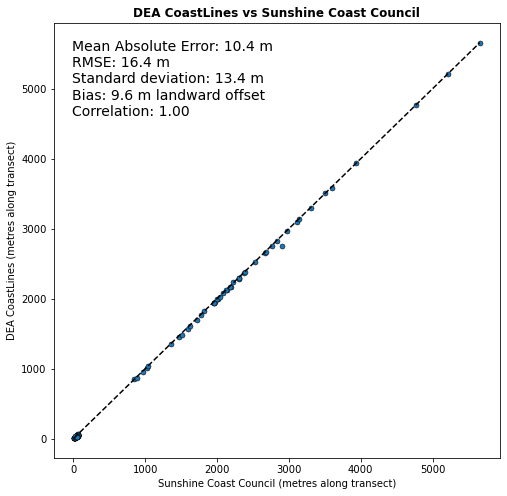

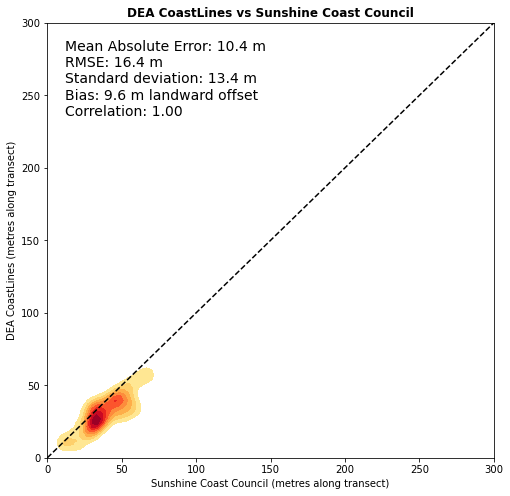

In [39]:
# Print stats and plot scatterplot
stats_subset = stats_df  #.query("deacl_dist < 3000")  #.loc[stats_df.id.isin(['bussleton_all_31'])]

def val_plot(df, 
             title='Validation',
             scatter=True, 
             density=True,
             time=True, 
             time_stat='mean',
             time_legend_pos=[0.8, 0.035],
             offset=0,
             extent=(0, 120),
             scatter_kwargs={}, 
             time_kwargs={}):
    
    # Copy data and apply offset
    df = df.copy()
    df['error_m'] += offset
    df['deacl_dist'] += offset

    # Compute stats  
    n, mae, rmse, stdev, corr, bias = deacl_val_stats(
        val_dist=df.val_dist, 
        deacl_dist=df.deacl_dist)    
    offset_str = 'landward offset' if bias > 0 else 'ocean-ward offset'

    if scatter:
        
        # Plot data as scatterplot
        fig, ax = plt.subplots(figsize=(8, 8))
        df.plot.scatter(x='val_dist',
                        y='deacl_dist',
                        s=25,
                        edgecolors='black',
                        linewidth=0.5,
#                         xlim=extent,
#                         ylim=extent,
                        ax=ax,
                        **scatter_kwargs)
        
        # Add dashed line
        
        
        ax.plot(
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                color='black',
                linestyle='dashed')
        
        ax.set_xlabel(f'{title} (metres along transect)')
        ax.set_ylabel(f'DEA CoastLines (metres along transect)')
        
        # Add annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Set title
        plt.gca().set_title(f'DEA CoastLines vs {title}', weight='bold')
        
        # Export to file        
        fig.savefig(f"{title}_scatter_offset{offset:.1f}.png", dpi=300)
        
    if density:
        
        fig, ax = plt.subplots(figsize=(8, 8))

        g = sns.kdeplot(ax=ax,
                        data=df.val_dist,
                        data2=df.deacl_dist, 
                        cmap='YlOrRd', 
                        shade=True,
                        bw=4,
                        shade_lowest=False,
                        clip=(extent, extent))

        g.set(xlabel=f'{title} (metres along transect)', 
              ylabel=f'DEA CoastLines (metres along transect)')
        ax.set_title(f'DEA CoastLines vs {title}', weight='bold')

        # Add stats annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Add diagonal line
        plt.gca().plot(np.linspace(*extent), 
                       np.linspace(*extent),
                       color='black',
                       linestyle='dashed')
        
        plt.gca().set_ylim(bottom=extent[0])
        plt.gca().set_xlim(left=extent[0])

        # Export to file
        fig = g.get_figure()
        fig.savefig(f"{title}_heatmap_offset{offset:.1f}.png", dpi=300)
        
    if time:
        
        # Group by beach and apply statistic
        stats_grouped = (df.groupby(['beach', 'year'], as_index=False)
                         .aggregate(time_stat)
                         .rename({'beach': 'id',
                                  'deacl_dist': 'DEA CoastLines',
                                  'val_dist': title}, axis=1)
                         .groupby('id')
                         .filter(lambda x: len(x) > 1))

        # Melt data into long format for faceted plotting
        stats_melted = pd.melt(stats_grouped, 
                               id_vars=['id', 'year'],
                               value_vars=['DEA CoastLines', title],
                               value_name='Distance (m)')

        # Plot facet data
        g = sns.relplot(data=stats_melted,
                        x="year", 
                        y="Distance (m)", 
                        col="id", 
                        hue="variable",
                        height=1.7, 
                        aspect=1.0, 
                        kind="line", 
                        legend='full', 
                        col_wrap=5,
                        **time_kwargs)
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(f'DEA CoastLines vs {title}', 
                       weight='bold', 
                       ha='right')
        
        # Simplify titles
        g.set_titles(row_template='{row_name}', 
                     col_template='{col_name}')

        # Customise legend
        g._legend.texts[0].set_text("")
        g._legend.set_bbox_to_anchor(time_legend_pos)
        
        # Export to file
        g.savefig(f"{title}_time_offset{offset:.1f}.png", dpi=300)
        
    return pd.Series({'Mean Absolute Error': mae, 
                    f'RMSE': rmse,
                    f'Standard deviation': stdev,
                    f'Bias': f'{bias:.1f} m {offset_str}',
                    f'Correlation': corr})

# for i, sub in stats_subset.groupby('smartline'):

#     # Run analysis
#     g = val_plot(df=sub,  # stats_subset,
#                  title=i.replace('/', '-'),
#                  scatter=True, 
#                  density=False,
#                  time=False,
#                  time_stat='median',
#                  time_legend_pos=[0.67, 0.11],
#                  offset=0,
#                  extent=(0, 1000))

# Run analysis
g = val_plot(df=stats_subset,  # stats_subset,
         title='Sunshine Coast Council',
         scatter=True, 
         density=True,
         time=False,
         time_stat='median',
         time_legend_pos=[0.67, 0.11],
         offset=0,
         extent=(0, 300))

In [ ]:
g = val_plot(df=stats_subset,  # stats_subset,
         title='All',
         scatter=False, 
         density=False,
         time=True,
         time_stat='median',
         time_legend_pos=[0.67, 0.11],
         offset=0,
         extent=(0, 300))

In [ ]:
out_data = []

for beach in stats_subset.beach.unique():

    # Run analysis
    g = val_plot(df=stats_subset.loc[stats_subset.beach == beach],
                 title=f'Sunshine Coast Council - {beach}',
                 scatter=True, 
                 density=False,
                 time=False,
                 time_stat='median',
                 time_legend_pos=[0.67, 0.11],
                 offset=0,
                 extent=(0, 120))
    
    out_data.append(g)

In [ ]:
pd.DataFrame(out_data)

In [ ]:
pd.DataFrame(out_data).loc[:, 'Correlation'].plot.hist()
plt.title('DEA Coastlines precision\n(correlation)')
plt.xlabel('Correlation (metres)')
plt.ylabel('n');


In [ ]:
pd.DataFrame(out_data).loc[:, 'Standard deviation'].plot.hist()
plt.title('DEA Coastlines precision\n(standard deviation of errors)')
plt.xlabel('Precision (metres)')
plt.ylabel('n');


In [ ]:
pd.DataFrame(out_data).loc[:, 'RMSE'].plot.hist()
plt.title('DEA Coastlines accuracy\n(root mean squared error)')
plt.xlabel('Accuracy (metres)')
plt.ylabel('n');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** March 2021